In [2]:
import pysal as ps  # requires PySAL version 1.14.  does not work with v2.x
import geopandas as gpd
import pandas as pd
import networkx as nx  # requires NetworkX version 2.2.  Does not work with v1.x 
from copy import deepcopy
import os
import matplotlib
import matplotlib.pyplot as plt
import fiona
from math import pi
from shapely.geometry import shape

# make sure you have the right PySAL and networkx versions
print('installed PySAL version: %s. Requires version 1.14' % ps.__version__)
print('installed NetworkX version: %s. Requires version 2.2' %  nx.__version__)

# set your workspace to the directory you downloaded this project to
workspace = r'G:\My Drive\GEOG 5541  Principles of Geocomputing\Group Project'

installed PySAL version: 1.14.4. Requires version 1.14
installed NetworkX version: 2.2. Requires version 2.2


## Pre-processing
We used the election return shapefile published by the Minnesota Legislature.  Unfortunately, we discovered that this shapefile contained many topology errors.  We used ArcMap to clean up these topology errors.

Many Minnesota voting precincts are entirely contained within other precincts.  This is especially the case in Greater Minnesota, where smaller towns and cities are their own precincts, and the surrounding unincorporated township is another.  This proved a serious problem for ensuring contiguity of districts, so we also used ArcMap to disolve most of these enclave precincts.

## parameters:
**shapefile (str) -** path to a polygon shapefile with fields for d_votes, r_votes, and population by precinct<br>
**d_votes (str) -** name of the field in the precinct shapefile that identifies the number of votes for the Democratic Party in that precinct.  All field names have a 10 character limit.  Stick to that limit or Bad Things will happen<br>
**r_votes (str) -** name of the field in the precinct shapefile that identifies the number of votes for the Republican Party in that precinct<br>
**population (str) -** name of the field in the precinct shapefile that identifies the population of the precinct<br>
**dist_num (str) -** name of the field in the shapefile that identifies the congressional district the precinct is in<br>
**party (str) -** 'd' to gerrymander in favor of the Democratic Party.  'r' for the Republican Party<br>
**num_dist (int) -** number of districts to create<br>
**num_pack (int) -** number of districts to pack with voters of the disfavored party, defaults to 1.  0 packed districts means the algorithm will attempt to evenly distribute voters of each party among districts.  -1 means the algorithm will only attempt to evenly distribute the population among districts, without respect to the distribution of each party's voters<br>

In [3]:
# given a shapefile showing votes by precinct, find statistically significant hotspots for 
# each party (HH for dems, LL for reps)
def hotspots(shapefile, d_votes, r_votes):
    
    #print(shapefile)
    
    # have pysal read the shapefile into a pandas dataframe
    data = ps.pdio.read_files(shapefile)
    
    # add a measure of vote % for one party. We're conly considering two parties, so the other party's 
    # vote % can be inferred
    #print(data.loc[0])
    
    for i in range(len(data)):
        data.loc[i, 'd_pct'] = (data.loc[i, d_votes]) / max((data.loc[i, r_votes] + data.loc[i, d_votes]), 1)  # prevent division by zero

    # use pysal.queen to determine precinct adjacencies.  Even though rook contiguity is required for
    # valid districts, queen is more appropriate for determining neighborhood clusters
    W = ps.queen_from_shapefile(shapefile)

    # call the Local Moran's I function from pandas for the DFL precentage of total votes
    moran = ps.Moran_Local(data.d_pct.values, W)
    
    # set sig equal to all of the precincts that with significant values < .05
    # these precincts are not randomly distributed
    sig = moran.p_sim < .05
    
    # the .q method gives the categories of each precinct.  1 means high DFL votes surrounded by other 
    # high DFL precincts, 3 means high republican vote precincts surrounded by other high Republican
    # precincts.  Multiplying by the T/F values in sig will return the category of each district if 
    # significant, 0 otherwise
    hotspots = moran.q * sig
    
    # convert the hotspots numpy array to a dictionary
    hotspots_dict = {i:hotspots[i] for i in range(len(hotspots))}
    
    return hotspots_dict
    

In [4]:
# given a polygon shapefile, convert it to a networkx contiguity graph with attribute values
# for each node corresponding to the shapefile attributes

def graph_from_shapefile(shapefile, d_votes, r_votes, population):

    # valid districts have rook contiguity between precincts.
    
    contig = ps.rook_from_shapefile(shapefile)

    # convert the PySAL contiguity object into a networkx graph
    
    G = nx.Graph()
    for i in contig:
        edge_list = [(i[0], neighbor) for neighbor in list(i[1].keys())]
        G.add_edges_from(edge_list)

    # add the FID to the graph as an attribute.  We need this because later we're going to change
    # the number of each node, but we can't lose the FID the node is associated with
    
    FID_values = {FID:FID for FID in G}
    nx.set_node_attributes(G, FID_values, name='FID')

    # we need add attribute information for d_votes, r_votes, and population from the shapefile to the graph
    # This can easily be genericized to cast any shapefile to graph
    
    attributes = ps.pdio.read_files(shapefile).loc[:, [d_votes, r_votes, population]]  # faster to use ps.pdio.read_files than gpd.read_file
    attribute_values = {i:dict(attributes.iloc[i]) for i in range(len(attributes))}  # gets dataframe values as a dictionary in a form that can be added to the graph
    nx.set_node_attributes(G, attribute_values)

    # add an attribute to the graph to represent the partisan advantage of the node, normalized by population
    
    partisan_values = {}
    for i in range(len(G)):
        partisanship = (G.nodes[i][d_votes] - G.nodes[i][r_votes]) / max(G.nodes[i][population], 1)
        partisan_values[i] = round(partisanship, 3)
    nx.set_node_attributes(G, partisan_values, name='Partisanship')

    # Our packing algorithm is prone to getting stuck on local maxima.  PySAL can determine
    # local Moran's I values for each precinct to identify large d-leaning clusters (High-High) and 
    # large r-leaning clusters (Low-Low).  We can add those codes to the graph as another attribute
    
    COType_values = hotspots(shapefile, d_votes, r_votes)
    
    nx.set_node_attributes(G, COType_values, name='COType')

    return G

In [5]:
# remove nodes from graph G either because they don't match the correct party cluster or because
# they are in a remove_list parameter
def remove_node(G, party=None, remove_list=None):
    G_subgraph = deepcopy(G)  

    if party == 'r':
        cluster_type = 1  # favoring r means packing dems
    if party == 'd':
        cluster_type = 3

    if remove_list == None:  # we're removing nodes based on party
        remove_list = [n for n in G if G.nodes[n]['COType'] != cluster_type]  
    G_subgraph.remove_nodes_from(remove_list)
    return G_subgraph

In [6]:
# pack the disfavored party into a small number of districts.  Calls itself rescursively to pack
# more than 1 district.
def pack(G, 
         d_votes, 
         r_votes, 
         population, 
         party, 
         num_dist, 
         num_pack=1, 
         district_array=[],
         target_size=0):


    if num_pack < 1:  # the base case
        return district_array, G
    num_pack -= 1

    # to start the packing algorithm, we want a subgraph with the most partisan precinct clusters
    # make a copy of G so we don't lose any information

    G_clusters = remove_node(G, party)



    # within the cluster subgraph, find the highest population contiguous cluster

    contig_clusters = list(nx.connected_components(G_clusters))
    if len(contig_clusters) == 1:
        biggest_cluster = contig_clusters[0]
    else:
        biggest_cluster = []
        biggest_cluster_pop = 0
        for cluster in contig_clusters:
            cluster_pop = sum([G_clusters.nodes[n][population] for n in cluster])
            if cluster_pop > biggest_cluster_pop:
                biggest_cluster_pop = cluster_pop
                biggest_cluster = cluster        

    # find the most partisan precinct inside the biggest cluster

    target_precincts = [(G_clusters.nodes[n]['Partisanship'], n) for n in biggest_cluster]
    target_precincts.sort()
    if party == 'r': # we finding the most d district to start packing, since we're favoring r
        starting_precinct = target_precincts[-1][1] 
    
    # republicans are much harder to pack, setting starting precincts to a corner of the state to 
    # make it easier
    if party == 'd':  
        if 933 in G.nodes:
            starting_precinct = 933
        elif 1549 in G.nodes:
            starting_precinct = 1549
        else: 
            starting_precinct = target_precincts[0][1]

    # Districts should have roughly even population, but the law does not require them to be exactly 
    # equal population. Within 10% is good enough.  In addition to packing the disfavored party's 
    # voters in a district, we can also make that district larger than average, diluting the 
    # disfavored party even more.  We're going to add some orphan districts later, so we can't go the 
    # full amount over, but 3% over equal size should be a good target

    if target_size == 0:
        total_pop = sum([G.nodes[n][population] for n in G])
        target_size = 1.03 * (total_pop / num_dist)  # 3% over equal population

    # initialize values with the starting precinct

    district_pop = G.nodes[starting_precinct][population]

    # all the neighbors of the starting precinct are available to choose the next precinct from
    # store them as a (partisanship, FID) tuple so we can sort by partisanship
    available = [(G.nodes[n]['Partisanship'], n) for n in list(G[starting_precinct])]
    
    # in the clean-up phase we're also going to want to sort the precincts inside the district
    # by partisanship, so we're storing them as the same (partisanship, FID) tuple
    district = [(G.nodes[starting_precinct]['Partisanship'], starting_precinct)]

    # pack the district:
    
    # initialize a new graph to hold the remaining precincts as we pack the district
    # we want a new graph so we don't lose any information from the original
    
    G_remaining = deepcopy(G)
    
    # remove the starting precinct
    G_remaining.remove_nodes_from([starting_precinct])
    
    
    while district_pop < target_size:
        # pick the precinct in the available list with the greatest partisan lean
        # remove it from the available list
        
        if party == 'r':
            available.sort(reverse=True)
        if party == 'd':
            available.sort()
        next_precinct = available.pop(0)[1]

        # add that precinct to the district
        district.append((G.nodes[next_precinct]['Partisanship'], next_precinct))

        # increase the district's population
        district_pop += G.nodes[next_precinct][population]
        
        # delete the node from the graph:
        G_remaining.remove_nodes_from([next_precinct])
        
        # add that precinct's neighbors to the available list, if they aren't in either the district 
        # or available list already
        for neighbor in list(G[next_precinct]):
            neighbor_tuple = (G.nodes[neighbor]['Partisanship'], neighbor)
            if neighbor_tuple not in available and neighbor_tuple not in district:
                available.append(neighbor_tuple)
        
        # adding the district might have created 1 or more groups of orphan precincts.  Add
        # those orphans to the district and remove them from G_remaining
        
            # this way of dealing with orphans doesn't work great, because it can add a huge chunk of 
            # orphans that make the district way too big.  This was a problem for packing Republicans, 
            # which was solved by specifying start precincts in the corners of the state
        
        while nx.is_connected(G_remaining) == False: 
            orphans = min(nx.connected_components(G_remaining), key=len)  # find the smallest groups of orphans first
            orphans_tuple = [(G.nodes[orphan]['Partisanship'], orphan) for orphan in orphans]
            district.extend(orphans_tuple)
            district_pop += sum([G.nodes[n][population] for n in orphans])
            G_remaining.remove_nodes_from(orphans)

    
    district = [FID for partisanship, FID in district]  # reduce the district to a list of just precinct FIDs
    
    # assign each precinct a district value of 'P'+ a number to differentiate the different
    # packed districts
    district_code = 'P'+str(num_pack)
    district_array.extend([(precinct, district_code) for precinct in district])

    if num_pack > 0:  # more districts to pack, so call the function again
        district_array, G_remaining = pack(G_remaining,
                                           d_votes, 
                                           r_votes, 
                                           population, 
                                           party, 
                                           num_dist, 
                                           num_pack, 
                                           district_array,
                                           target_size)
    
    return district_array, G_remaining

In [7]:
# this is code we wrote to try to solve the orphan problem with packing districts.  It does create
# districts without orphans, but it takes an incredibly long time to run (over 30 mins) because it 
# checks dozens of candidate precincts every iteration, creating a new subgraph for each of them.  It
# also results in extremely non-compact districts.  It was also only needed for Republicans because
# they are so spread out.  In the end, it was easier to just specify the starting districts if we
# wanted to pack Republicans.  We're keeping it in the notebook to document that this type of 
# solution doesn't work.

# check to make sure adding the candidate won't break the contiguity of the remaining precincts
        
        #for i in range(len(available)):
            #next_precinct_candidate = available[i][1]
            
            # make a subgraph to see if adding the candidate will result in non-contiguity
            #subgraph = G_remaining.subgraph([n for n in G_remaining.nodes if n != next_precinct_candidate])
            
            
            #if nx.is_connected(subgraph) == False:
                #print('orphans created')
                #while nx.is_connected(subgraph) == False: 
                    #print(len(list(nx.connected_components(subgraph))))
                    
                    # if the discontinuity creates more than 5 orphan precincts in the smallest group
                    # of orphans, move to the next candidate
                    #if len(min(nx.connected_components(subgraph), key=len)) > 5: 
                        #print('that is a lot of orphans, trying another precinct')
                        #break
                    #print('that is not so many orphans, adding them to the district')
                    
                    # otherwise, add the orphans to the district until contiguity is restored
                    #orphans = min(nx.connected_components(subgraph), key=len)  # find the smallest groups of orphans first
                    #orphans_tuple = [(G.nodes[orphan]['Partisanship'], orphan) for orphan in orphans]
                    #district.extend(orphans_tuple)
                    #district_pop += sum([G.nodes[n][population] for n in orphans])
                    #print('population after adding orphans:', district_pop)
                   #G_remaining.remove_nodes_from(orphans)
                #continue  
            #else:
                #print('no orphans')
                #next_precinct = available.pop(i)[1]
                #print('Adding', next_precinct, 'Population:', district_pop, 'Need:', target_size-district_pop)
                #break

In [8]:
# METIS  (http://glaros.dtc.umn.edu/gkhome/metis/metis/overview) will divide precincts in such a way 
# that maximizes compactness, ensures roughly equal districts and spreads each party's voters evenly 
# (i.e. will crack the districts).  But it needs a file in a very particular format.  Given a graph, 
# reformat it into a file that METIS can read.  
def graph_to_metis(G, d_votes, r_votes, population, num_dist, num_pack):
    
    with open('METIS_input.txt', 'w') as fh:
        
        # metis needs the number of nodes and the number of edges as a header.  
        # 010 is the code to tell METIS the nodes are weighted.  The '3' tells METIS
        # that we are passing it three weights for each node.  See page 9 of the METIS
        # manual for more information about input file formats

        
        if num_pack > -1:  
            fh.write(str(len(G.nodes))+' '+str(len(G.edges))+' 010 3\n')
        else:
            fh.write(str(len(G.nodes))+' '+str(len(G.edges))+' 010 1\n') # -1 signifies that METIS should not try to balance r_votes and d_votes (i.e. districts based only on population)

        # METIS needs nodes to be numbered as consecutive integers.  
        G_renumbered = nx.convert_node_labels_to_integers(G, 1)

        for n in G_renumbered:
            weight1 = int(G_renumbered.nodes[n][population])
            weight2 = int(G_renumbered.nodes[n][r_votes])
            weight3 = int(G_renumbered.nodes[n][d_votes])
            neighbors = ' '.join(list(str(neighbor) for neighbor in G_renumbered[n]))  # list of neighbors as a space delimited string

            # METIS expects to see the node weights first, then the neighbors.  1 node on each line
            if num_pack > -1:
                fh.write(str(weight1)+' '+str(weight2)+' '+str(weight3)+' '+neighbors+'\n')
            else:
                fh.write(str(weight1)+' '+neighbors+'\n')  
            
    # print out a METIS command to use with the METIS_input file
    if num_pack > -1:
        
        # ubvec indicates how much METIS should try to balance the weights.  This value indicates that
        # METIS should not try to let the population weight vary at all between subgraphs, but that the
        # two other weights can go up to 8% over an even distribution.  This is only a starting point,
        # and will need to be adjusted in METIS to produce a high quality partition.
        ubvec = '1 1.08 1.08'  
    else:
        ubvec = '1'
    print("METIS command line entry: gpmetis METIS_input.txt %s -contig -ubvec='%s' -ncuts=100" % (num_dist-(max(num_pack, 0)), ubvec))
    
    metis_output = 'METIS_input.txt.part.'+str(num_dist-(max(num_pack, 0)))  # the filename METIS will output given the command line code above
    return metis_output

In [9]:
# join the METIS output file to the original shapefile.  Print some statistics about the districts
def metis_to_gdf(metis_output, shapefile, d_votes, r_votes, population):
    # read the METIS output

    with open(metis_output, encoding='cp850') as fh:
        metis_output = fh.read()

    # METIS output includes the newline character, so striding through by 2 gives just the output values
    metis = [line for line in metis_output[::2]]

    # zip the METIS output with the FID's from the subgraph of the remaining precincts that weren't packed
    FID = [G_remainder.nodes[n]['FID'] for n in G_remainder]
    district_assignment = list(zip(FID, metis))

    # add the packed district list from above to the district_assignment and turn it into a dataframe
    district_assignment.extend(packed_district)
    district_frame = pd.DataFrame(district_assignment)

    # change the column names so we can merge it with the shapefile geodataframe
    district_frame = district_frame.rename(index=str, columns={0: 'FID', 1: 'District'})

    # join the METIS output dataframe to the original shapefile

    #shapefile = 'Current_dissolved.shp'
    #d_votes = 'SUM_USPRSD'
    #r_votes = 'SUM_USPRSR'
    #population = 'SUM_USPRST'

    # join the district assignment dataframe to the original shapefile
    district_map = gpd.read_file(shapefile).loc[:, [d_votes, r_votes, population, 'geometry']]

    for i in range(len(district_map)):
        district_map.loc[i, 'FID'] = i

    district_map = district_map.merge(district_frame, on='FID')

    # generate summary statistics for the districts
    statistics = district_map.groupby('District').sum().loc[:, [d_votes, r_votes, population]]

    # calculate the vote percentage for the Democratic Party
    for index in statistics.index.values:
        statistics.loc[index, 'dem%'] = statistics.loc[index, d_votes] / (statistics.loc[index, d_votes] + statistics.loc[index, r_votes])

    # make sure the largest precinct is no more than 10% larger than the smallest
    validate = (max(statistics.loc[:, population]) / min(statistics.loc[:, population])) <= 1.1

    # calculate how many districts were won by the Democratic party
    d_wins = len([district for district in statistics.loc[:, 'dem%'] if district > .5])    


    # display the statistics
    print('Valid:', validate)
    print('Democratic Districts:', d_wins)
    display(statistics)
    
    return district_map
    

In [10]:
# the gerrymandered maps contain polygons of all 4120 precincts with their district assignment as an 
# attribute, but we just want maps of the 8 districts, so we need to dissolve all the gerrymandered 
# maps

def iter_dissolve(workspace, dist_num):
    # get the filepath of the directory where the gerrymandered are stored
    directory = os.path.join(workspace, r'gerrymandering\gerrymandered precincts')
    
    # make a directory to store the dissolved maps
    dissolve_dir = 'finished shapefiles'
    os.mkdir(dissolve_dir)

    # the shapefiles are stored in subfolders in this directory.  Iterate through all the subfolders to
    # dissolve all the shapefiles
    for folder in os.listdir(directory):
        folder_path = os.path.join(directory, folder)
        for filename in os.listdir(folder_path):
            if filename.endswith(".shp"):
                filepath = os.path.join(folder_path, filename)
                dissolver(dissolve_dir, filepath, filename, dist_num)
            else:
                continue

In [11]:
#After gerrymandering, the data has 8 districts. 
#We use Geopandas library to dissolve by district field. And create a new ESRI Shapefile.

def dissolver(dissolve_dir, filepath, filename, dist_num):
    map1 = gpd.read_file(filepath) #reads shapefile
    

    # because not all the gerrymandered maps were created from the shapefile where enclave towns were
    # dissolved into their surrounding townships, some of the column names are different on some
    # of the files.  This line fixes that.  
    map1=map1.rename(index=str, columns={'SUM_USPRSR':'USPRSR', 'SUM_USPRSD':'USPRSDFL', 'SUM_USPRST': 'USPRSTOTAL'})

    # dissolve the district map by district to create an output with just 8 polygons
    mapdiss = map1.dissolve(by=dist_num,aggfunc='sum')
    
    # add a column showing the percentage of the vote going to Democrats
    for index in mapdiss.index.values:
        mapdiss.loc[index, 'dem%'] = mapdiss.loc[index, d_votes] / (mapdiss.loc[index, d_votes] + mapdiss.loc[index, r_votes])


    # save the dissolved map
    filepath = os.path.join(dissolve_dir, filename)
    
    mapdiss.to_file(filepath, driver='ESRI Shapefile')

    #display(mapdiss.plot(cmap='plasma'))
    #display(mapdiss.head(8))

In [12]:
def iter_plot(workspace):
    # get the directory where the dissolved shapefiles are stored
    directory = os.path.join(workspace, r'gerrymandering\finished shapefiles')
    
    # plot numbering starts at 1, not 0
    plot_number = 1
    
    plt.figure(figsize=(9,18))
    
    # iterate through the files and plot each one as a subplot
    for filename in os.listdir(directory):
        if filename.endswith('.shp'):
            map = gpd.read_file(os.path.join(directory, filename))
            
            # calculate the number of wins for each party
            d_wins = len([district for district in map.loc[:, 'dem%'] if district > .5]) 
            r_wins = len([district for district in map.loc[:, 'dem%'] if district < .5])
            ax = plt.subplot(7, 3, plot_number)
            map.plot(cmap='tab10', ax=ax)
            ax.set_title(filename)
            ax.set_xlabel('Democratic districts: %s\nRepublican districts: %s' %(d_wins, r_wins))
            ax.set_xticks(())
            ax.set_yticks(())
            
            # Go to the next plot for the next loop
            plot_number = plot_number + 1

        else:
            continue
    
    plt.tight_layout()

In [13]:
#Efficiency gap is being used for measuting Gerrymandering quality. Wasted votes are bases of the function. 

def iter_efficiency(workspace):
    
    MapNumber=0
    
    directory=os.path.join(workspace, 'gerrymandering', 'finished shapefiles')

    for file in os.listdir(directory): #iterates through every item in the folder
        i = os.path.join(directory, file)
        if i.endswith('.shp'): 
            fh=fiona.open(i,'r') #opens a shapefile at a time and loops through
            TotalWastedDemocrat=0
            TotalWastedRep=0
            TotalVotes=0
            MapNumber+=1
            print(file) #prints file name
            for f in fh:
                repVotes = f['properties']['USPRSR'] #get the republican votes
                demVotes = f['properties']['USPRSDFL'] #get the democrat votes
                totVotes = repVotes + demVotes #total votes by precints of Democrat and Republican Party
                TotalVotes=TotalVotes+totVotes #overall total votes (Republican+Democrat)
                if repVotes > demVotes: #if republican won
                    wastedRVotes = int(( (repVotes - demVotes)/2) - 1) #wasted republican votes
                    wastedDVotes = demVotes #wasted democrat votes
                elif demVotes > repVotes: #if democrat won
                    wastedDVotes = int(( (demVotes - repVotes)/2) - 1) #wasted democrat votes
                    wastedRVotes = repVotes #wasted republican votes
                TotalWastedDemocrat=TotalWastedDemocrat+wastedDVotes # total wasted votes by democrats
                TotalWastedRep=TotalWastedRep+wastedRVotes #total wasted votes by republicans
            fh.close # Close the file
            effGap=((TotalWastedDemocrat - TotalWastedRep)/TotalVotes)*100 #overall efficiency gap (percentage)
            if TotalWastedDemocrat>TotalWastedRep:
                print('Efficiency gap is in favor of Republicans')
            else:
                print('Efficiency gap is in favor of Democrats')
            print('%',effGap)

In [14]:
def iter_compactness(workspace):
    directory = os.path.join(workspace, 'gerrymandering', 'finished shapefiles')
    mapNumber = 1
    for shapeFile in os.listdir(directory): 
        if shapeFile.endswith('.shp'):
            filepath = os.path.join(directory, shapeFile)
            print (shapeFile)
            fh = fiona.open(filepath, 'r')

            compactnessSum = 0 #aggregates the compactnesses of each district in order to be divided for average compactness
            districtNumber = 0 

            for f in fh:
                shp_geom = shape(f['geometry']) #loads shape into shapely
                per = shp_geom.length #perimeter of polygon is found by length function in shapely
                area = shp_geom.area #area of the district
                compactnessSum += compactness(area, per) 
                districtNumber += 1 
                print ("District", districtNumber, ":", compactness(area, per)) #prints district with corresponding compactness

            overallCompactness = compactnessSum / 8

            print ("Average compactness: ", overallCompactness, "\n") #finds average compactness of map's districts
            mapNumber += 1 
            fh.close

In [15]:
def compactness(area, perimeter):
    perimeterCircleArea = (perimeter ** 2) / (4 * pi) 
    #finds the area of a circle whose circumference is the same as the district's perimeter length
    ratio =   area / perimeterCircleArea
    #final ratio of the actual area of the district compared to the computed area from the perimeter
    return (ratio)

## Running the Analysis
With the functions defined, we can actually start getting some results

In [16]:
# obtain graph G from the input shapefile. You only need to do this once per shapefile
G = graph_from_shapefile('Current_dissolved.shp',
                         'SUM_USPRSD',  # field names have 10 character limit.  Make sure you keep to it or Bad Things will happen
                         'SUM_USPRSR',
                         'SUM_USPRST')

In [17]:
# establish a party to favor, the number of desired districts, and the number of districts that 
# should be packed with the disfavored party

party = 'r'
num_dist = 8
num_pack = 1

# get a list of precincts in the packed district and a graph of the leftover districts. 
packed_district, G_remainder = pack(G,
                                    d_votes='SUM_USPRSD', 
                                    r_votes='SUM_USPRSR',
                                    population='SUM_USPRST',
                                    party=party,
                                    num_dist=num_dist,
                                    district_array=[],  # weird bug where if this default is not explicitly assigned, district_array will assign every precinct to itself again if this function is run again.
                                    num_pack=num_pack)

In [18]:
# creates an input file and a command line command to run in METIS.  Returns the filename that METIS
# will output.  See the METIS documentation for more information.  Because we packed in favor of
# Republicans in the previous function call, this partition will end up creating a map that favors
# Republicans. 
metis = graph_to_metis(G=G_remainder, 
                       d_votes='SUM_USPRSD',
                       r_votes='SUM_USPRSR',
                       population='SUM_USPRST',
                       num_dist=num_dist,
                       num_pack=num_pack)

METIS command line entry: gpmetis METIS_input.txt 7 -contig -ubvec='1 1.08 1.08' -ncuts=100


Now you'll need to input the graph file into METIS.  Things will be easier if you put the METIS application in the same folder as this notebook.  After you run the METIS analysis, you can continue to run the Python code in this notebook with the METIS output file.  An example METIS output file (METIS_input.txt.part.7) was included in the .zip archive with this notebook for testing

In [19]:
# join the METIS output to the original shapefile, ensure the districts have valid populations, 
# check how many districts were won by democrats, and display some summary statistics
district_map = metis_to_gdf(metis, 
                            shapefile='Current_dissolved.shp', 
                            d_votes='SUM_USPRSD',
                            r_votes='SUM_USPRSR',
                            population='SUM_USPRST')



Valid: True
Democratic Districts: 1


,SUM_USPRSD,SUM_USPRSR,SUM_USPRST,dem%
District,,,,
0,163711.0,189592.0,385710.0,0.463373
1,141932.0,190380.0,361853.0,0.427105
2,163603.0,165737.0,361991.0,0.496760
3,163380.0,184411.0,380483.0,0.469765
4,163249.0,174999.0,370210.0,0.482631
5,132859.0,190725.0,354390.0,0.410586
6,163227.0,179186.0,376752.0,0.476696
P0,296162.0,51090.0,379522.0,0.852873


In [13]:
# uncomment the code below save this dataframe as a shapefile

# district_map.to_file('district_map.shp') 

We used variations on the above process to generate 17 different partitions, which are saved as shapefiles in the 'gerrymandered precincts' directory.  These shapefiles include every precinct, with the precinct's district assignment as an attribute.  To display and further analyze the districts, the precincts will have to be dissolved.  The output of these dissolve is already stored in the 'finished shapefiles' directory, but you can uncomment the code to run the dissolves again (just make sure you rename the 'finished shapefiles' directory first)

In [329]:
# iterate through all of the shapefiles in the gerrymandered precincts directory and dissolve them
# by the 'District' field

# the disolving has already been done and the files included in the 'finished shapefiles' directory.
# you can uncomment the code below to run it again

#iter_dissolve(workspace, 'District')

In [330]:
# Dissolve the current precinct map by the 'CONGDIST' field, which indicates the current congressional
# district that precinct is assigned to.

# the disolving has already been done and the file included in the 'finished shapefiles' directory.
# you can uncomment the code below to run it again

#filename = 'Current.shp'
#filepath = os.path.join(workspace, 'gerrymandering', filename)
#dissolver('finished shapefiles', filepath, filename, 'CONGDIST')

## Results

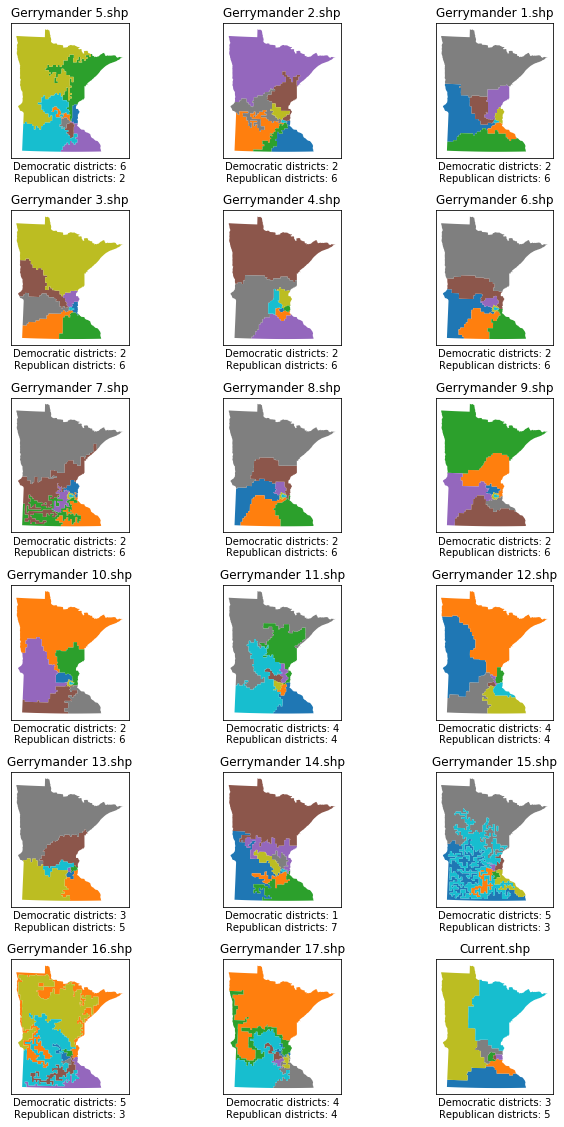

In [20]:
# iterate through all the dissolved shapefiles and plot them
iter_plot(workspace)

With dissolved districts, we can calculate the effeciency gap for each map.  Efficiency gap is a measure of the ratio of wasted votes between the two major parties.  A vote is considered "wasted" if it was cast for a losing candidate or if it expanded the winner's margin of victory above and beyond the minimum value required to win.  

Efficiency gap is a good measure of gerrymandering because it is modeled after the packing and cracking processes that create gerrymandered districts.  When a disfavored party is packed into a single district which they win overwhelmingly, they have lots of wasted votes (because there were many votes over the required margin) and the favored party has few (since the loser received so few votes).  When the disfavored party's voters are cracked among the remaining districts, the favored party has a low number of wasted votes (because they won by a low margin) while the disfavored party has many (because the losing candidate received a relatively high percentage of votes).

In [21]:
iter_efficiency(workspace)

Gerrymander 5.shp
Efficiency gap is in favor of Democrats
% -24.22570450260157
Gerrymander 2.shp
Efficiency gap is in favor of Republicans
% 26.19293628262021
Gerrymander 1.shp
Efficiency gap is in favor of Republicans
% 26.511214029399998
Gerrymander 3.shp
Efficiency gap is in favor of Republicans
% 27.136669842615476
Gerrymander 4.shp
Efficiency gap is in favor of Republicans
% 26.615133855440444
Gerrymander 6.shp
Efficiency gap is in favor of Republicans
% 26.648879863466483
Gerrymander 7.shp
Efficiency gap is in favor of Republicans
% 26.955350232162107
Gerrymander 8.shp
Efficiency gap is in favor of Republicans
% 26.955350232162107
Gerrymander 9.shp
Efficiency gap is in favor of Republicans
% 25.238438267526135
Gerrymander 10.shp
Efficiency gap is in favor of Republicans
% 27.37196087156331
Gerrymander 11.shp
Efficiency gap is in favor of Republicans
% 0.07666215481778561
Gerrymander 12.shp
Efficiency gap is in favor of Republicans
% 1.7302464799486883
Gerrymander 13.shp
Efficienc

And we can calculate the compactness of each district.  The most compact shape possible is a circle.  The compactness scores for each map represent the ratio of the area of the districts to the area of a circle with the same perimeter.  So a compactness score of 0.10 represents a district that takes up 10% of the area that a perfectly compact shape with the same perimeter would take up.

Compactness is another way to measure gerrymandering, because weirdly shaped districts are a good indicator of purposeful attempts to assign particular voters to particular districts.

In [22]:
iter_compactness(workspace)

Gerrymander 5.shp
District 1 : 0.37927004822135246
District 2 : 0.05270251034174754
District 3 : 0.07781518790817245
District 4 : 0.2372980340434414
District 5 : 0.3268710598375012
District 6 : 0.2102183170673092
District 7 : 0.08881754947015955
District 8 : 0.09488094993239425
Average compactness:  0.18348420710275976 

Gerrymander 2.shp
District 1 : 0.3204426399932454
District 2 : 0.09705966418893065
District 3 : 0.09590213453362378
District 4 : 0.16831772356733726
District 5 : 0.17290319852411096
District 6 : 0.05684523715376424
District 7 : 0.2490027953089091
District 8 : 0.22830882836846136
Average compactness:  0.17359777770479784 

Gerrymander 1.shp
District 1 : 0.24202941404754358
District 2 : 0.21747042003212183
District 3 : 0.3179254698685731
District 4 : 0.3074885332410475
District 5 : 0.24373910734944265
District 6 : 0.25991010283328086
District 7 : 0.41115728410066177
District 8 : 0.22830882836846136
Average compactness:  0.27850364498014163 

Gerrymander 3.shp
District 1 

## Discussion

Currently, Minnesota's districts moderately favor Republicans.  The efficiency gap is about 12.8% in their favor, which is why 5 of Minnesota's 8 districts are categorized as "Republican" even though the Republican party received a minority of the vote in the 2016 election.  This moderate bias results in Republicans being favored in 1 more seat than they would with 0% efficiency gap.  That falls below the 2 seat threshold of presumptive unconstitutionality suggested by Stephanoplous and McGhee in their original paper outlining the efficiency gap.  

While 5 of the 8 districts were held by Democrats after the 2016 election, that result is due to conservative Democrats in the 1st and 7th districts outperforming the partisan lean of their districts by substantial amounts.

Despite the pro-Republican bias in the current districts, the shapes of the districts themselves is relatively compact, with an average compactness of about 32.4%.  This relatively high value indicates that the people who drew up Minnesota's district map did not go to great extremes to microtarget particular areas for gerrymandering.

The most interesting maps produced by our algorithms are #4, #5, and #14

Map #4 is interesting because it expands the pro-Republican bias of the status quo, more than doubling the efficiency gap to nearly 26%.  This puts map #4 above the 2 seat threshold suggested by Stephanopolous and McGhee as unconstitutional.  Interestingly, this expansion decreases compactness only marginally relative to the status quo, to 30.2%.  This map shows that it is possible to create extremely skewed results without sacrificing compactness.

Map #5 is interesting because it was the largest pro-Democrat gerrymander we were able to create.  With a 6-2 advantage and a efficiency gap of over 24%, this map also passes the 2-seat threshold.  Unlike Map #4, this pro-Democrat gerrymander required substantial sacrifices in compactness, with a score of just 18%.

Finally, Map #14 shows the largest pro-Republican gerrymander we were able to create, with a 7-1 advantage.  Because Republicans are a minority of voters in the state, 7-1 is the theoretical maximum possible advantage.  This map was only possible with a substantial decrease is compactness, with a score of about 12%

The patterns in Maps #4, #5, and #15 show that it is easier to create pro-Republican gerrymanders in Minnesota.  The distribution of voters within the state helps explain why those patterns exist.  In St. Paul and Minneapolis, about 85% of voters vote Democratic.  So it is easy to pack Democratic voters into a single district without losing very many Republican voters in the seven remaining districts.  The most Republican parts of the state, however, are not nearly as concentrated.  It is not possible to pack many Republicans into a single district without removing a significant number of Democrats from the remaining districts.